# Tools 2 Final Project

Jen Lee
Connie Chang

In [1]:
import pandas as pd
import geopandas as gpd
import re
import numpy as np
import seaborn as sns
from shapely.geometry import Point
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

## Data Gathering

#### AirBnb Data

Source: http://insideairbnb.com/get-the-data.html

|Date Compiled |County/City|File Name   |Description |
|:-------------|:---------:|:----------:|-----------:|
|29 March, 2021|Denver     |listings.csv|Summary information and metrics for listings in Denver (good for visualisations).|
|29 March, 2021|Denver     |reviews.csv|Summary Review data and Listing ID (to facilitate time based analytics and visualisations linked to a listing).|
|N/A|Denver     |neighbourhoods.csv| Neighbourhood list for geo filter. Sourced from city or open source GIS files.|
|N/A|Denver     |neighbourhoods.geojson| GeoJSON file of neighbourhoods of the city.|

#### Other Data

|Source |File Name   |Description | URL |
|:-------------|:---------:|:----------:|-----------:|
|Wikipedia|neighbourhoods_den.csv   |Groups the Denver Neighbourhoods into Areas| https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Denver |



In [2]:
# listings.csv
listings = pd.read_csv("./data/denver_03_29_2021/listings.csv")
print(f"listings shape: {listings.shape}")
listings.sample(3)

listings shape: (3394, 74)


,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
2281,42492604,https://www.airbnb.com/rooms/42492604,20210329150448,2021-03-30,Monthly Furnished Apt Rental Near Downtown Denver,"2 blocks West of Broadway shopping and dining,...","Few blocks west of Broadway, on Bayaud Ave, t...",https://a0.muscache.com/pictures/4ae3e7ca-cbcb...,338377982,https://www.airbnb.com/users/show/338377982,...,10.0,10.0,9.0,NaN,t,5,5,0,0,0.27
1689,34813376,https://www.airbnb.com/rooms/34813376,20210329150448,2021-03-31,LOHI - Best Location in Denver,Right in the Heart of one of the hottest neigh...,You can literally access anything you want/nee...,https://a0.muscache.com/pictures/09409776-6ad0...,78300099,https://www.airbnb.com/users/show/78300099,...,10.0,10.0,10.0,2020-BFN-0001910,f,1,1,0,0,5.32
2284,42519821,https://www.airbnb.com/rooms/42519821,20210329150448,2021-03-30,Duplex in Sunnyside neighborhood near lightrail,NaN,NaN,https://a0.muscache.com/pictures/217cc917-c577...,87657028,https://www.airbnb.com/users/show/87657028,...,NaN,NaN,NaN,NaN,f,2,2,0,0,NaN


In [3]:
# reviews.csv
reviews = pd.read_csv("./data/denver_03_29_2021/reviews.csv")
reviews.sample(3)

,listing_id,id,date,reviewer_id,reviewer_name,comments
157874,33582543,550889284,2019-10-19,86506618,Karina,Chloe's place was wonderful! Stylish and comfo...
173550,39389443,731988415,2021-02-16,79656746,Marina,Clean & convenient. Loved the underground park...
60501,14369542,573581418,2019-12-06,289024718,Nathaniel,"Clean, high quality and private experience. Th..."


In [4]:
# neighbourhoods.csv
neighborhoods = pd.read_csv("./data/denver_03_29_2021/neighbourhoods.csv")
neighborhoods.sample(3)

,neighbourhood_group,neighbourhood
51,NaN,Regis
0,NaN,Athmar Park
35,NaN,Highland


In [5]:
# neighbourhoods.geojson
neighborhoods_gdf = gpd.read_file("./data/denver_03_29_2021/neighbourhoods.geojson")
neighborhoods_gdf.sample(3)

,neighbourhood,neighbourhood_group,geometry
23,College View - South Platte,None,"MULTIPOLYGON (((-105.00140 39.68217, -105.0013..."
33,Harvey Park South,None,"MULTIPOLYGON (((-105.02511 39.66772, -105.0251..."
29,Hampden,None,"MULTIPOLYGON (((-104.86602 39.66027, -104.8663..."


In [6]:
# neighbourhoods_den.csv
neighbourhoods_group = pd.read_csv("./data/neighbourhoods_den.csv")
neighbourhoods_group.sample(3)

,neighbourhood_cleansed,neighbourhood_group
37,Gateway - Green Valley Ranch,Northeast
76,Villa Park,West
30,Globeville,North


## Data Cleaning

In [7]:
# remove unneeded columns from listings 
listings.drop(columns=["picture_url", "host_url", "host_thumbnail_url", "host_picture_url", "license", 'scrape_id', 
               'listing_url','last_scraped', 'neighborhood_overview','host_verifications' ,
               'host_about', 'host_thumbnail_url','amenities','host_neighbourhood', 'neighbourhood', 'name',
               'description','host_name', 'calendar_last_scraped'], axis=1, inplace=True)

In [8]:
# Clean up the "bathrooms_text" column to make two new columns - number of bathrooms, and a boolean column to indicate if bthrooms are private
def get_bathrooms_num(x):
    if type(x) != str:
        return 0.0
    elif x == "Shared half-bath" or x == "Half-bath":
        return 0.5
    elif "shared bath" in x:
        return float(x.strip("s").strip("shared bath"))
    elif "private bath" in x:
        return float(x.strip("s").strip("private bath"))
    elif "bath" in x:
        return float(x.strip("s").strip("bath"))
    else:
        return 0.0
    
# Returns "t" & "f" beacuse that's how the other booleans are formatted
def get_is_private_bathroom(x):
    if type(x) != str:
        return np.NaN
    elif "shared" in x:
        return "f"
    else:
        return "t"

listings["bathrooms"] = listings["bathrooms_text"].apply(lambda x: get_bathrooms_num(x))
listings["private_bathroom"] = listings["bathrooms_text"].apply(lambda x: get_is_private_bathroom(x))
listings = listings.drop("bathrooms_text", axis=1)

In [9]:
# Convert the latitude & longitude values to Point() values, to be used later for plotting
listings["coordinates"] = [Point(xy) for xy in zip(listings.longitude, listings.latitude)]
listings = listings.drop("longitude", axis=1)
listings = listings.drop("latitude", axis=1)

### Add neighbourhoods_group

In [10]:
# Merge neighbourhoods_group df into listings
listings = pd.merge(listings, neighbourhoods_group, on='neighbourhood_cleansed',  
         how='left', validate='m:1')

listings[['neighbourhood_cleansed','neighbourhood_group']].sample(5)

,neighbourhood_cleansed,neighbourhood_group
2039,Five Points,North
2398,Athmar Park,West
2424,Lincoln Park,Central
381,Speer,Central
461,CBD,Central


### Price Field
'price' field is with type: object. It needs to remove '$' and ',' then convert to numeric.

In [11]:
print(f"listing price initial type: {listings.price.dtype}")

# drop the record with price = 0
listings = listings[listings['price']!='$0.00']

# remove '$' and ','
listings['price'] = listings['price'].str.strip('$')
listings['price'] = listings['price'].str.replace(',', '')

# convert to numeric
listings['price'] = pd.to_numeric(listings['price'])

print(f"listing price after cleaning type: {listings.price.dtype}")

listings['price'].describe()

listing price initial type: object
listing price after cleaning type: float64


count    3393.000000
mean      157.756263
std       244.777158
min        22.000000
25%        79.000000
50%       115.000000
75%       175.000000
max      9999.000000
Name: price, dtype: float64

### Convert Data Types
1. Convert to numeric: ```host_response_rate``` and ```host_acceptance_rate``` are object, remove '%' and convert to numeric
2. Convert to Ordinal: ```host_since```, ```first_review```, ```last_review```

In [12]:
# Remove % sign and convert the data type to numeric
listings['host_response_rate'] = pd.to_numeric(listings['host_response_rate'].str[:-1])
listings['host_acceptance_rate'] = pd.to_numeric(listings['host_acceptance_rate'].str[:-1])

# Datetime format:
listings.host_since = pd.to_datetime(listings.host_since, format='%Y-%m-%d')
listings.first_review = pd.to_datetime(listings.first_review, format='%Y-%m-%d')
listings.last_review = pd.to_datetime(listings.last_review, format='%Y-%m-%d')

# Fill NA with 03/29/2012 (date data was scraped since we know they were at least a host since then)
listings['host_since'] = listings['host_since'].fillna(pd.datetime(year=2021, month=3, day=29))
listings['first_review'] = listings['first_review'].fillna(pd.datetime(year=2021, month=3, day=29))
listings['last_review'] = listings['last_review'].fillna(pd.datetime(year=2021, month=3, day=29))

# To Ordinal
listings['host_since'] = listings['host_since'].apply(lambda x: x.toordinal())
listings['first_review'] = listings['first_review'].apply(lambda x: x.toordinal())
listings['last_review'] = listings['last_review'].apply(lambda x: x.toordinal())

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  if sys.path[0] == '':
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  del sys.path[0]


### Fill in NA
1. ```Bedrooms``` field with blank are the ones that either a studio, or an open space without separate room as a bedroom, so we fill it with 0.
2. ```Beds``` field with blank typically means that the listing host missed the field. The main point of airbnb is bed, we'd assume they have at least 1 bed, so fill in the blank ones with 1.
3. ```Reviews_per_month``` field with blank means there's no review at all. Thus, the ```first_review``` and ```last_review``` fields are both blank. We'd fill the ```reviews_per_month``` with 0.
4. Fill numerical columns with mean.
5. Fill categorical columns with 'missing'.

In [13]:
# FunctionTransformer for fill NA 
from sklearn.preprocessing import FunctionTransformer
def custom_transformation(df):
    df['bedrooms'].fillna(0, inplace=True)
    df['beds'].fillna(1, inplace=True)
    df['reviews_per_month'].fillna(0, inplace=True)

ft = FunctionTransformer(func=custom_transformation, validate=False)
ft.fit_transform(listings)

In [14]:
#Numeric columns :
numFeatures = listings.select_dtypes(include=['int64', 'float64']).columns
numFeatures

Index(['id', 'host_id', 'host_since', 'host_response_rate',
       'host_acceptance_rate', 'host_listings_count',
       'host_total_listings_count', 'neighbourhood_group_cleansed',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_updated', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'first_review', 'last_review', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calc

In [15]:
listings[numFeatures] = listings[numFeatures].fillna(listings[numFeatures].mean()) # fill numberical columns with mean

In [16]:
# Categorical columns :
# Drop coortinates then get any remaining columns
catFeatures = listings.drop(['coordinates'], axis=1).select_dtypes(include=['object']).columns
catFeatures

Index(['host_location', 'host_response_time', 'host_is_superhost',
       'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'property_type', 'room_type',
       'has_availability', 'instant_bookable', 'private_bathroom',
       'neighbourhood_group'],
      dtype='object')

In [17]:
listings[catFeatures] = listings[catFeatures].fillna('missing') # fill categorical columns with 'missing'

### Dropping Any Remaining Data that can't be Cleaned
1. Drop all NA columns ```neighbourhood_group_cleansed```, ```calendar_updated```
2. There are 4 records with NA in the ```bathrooms_text``` field, which be previously convertyed to ```private_bathroom```.
3. Drop records with NA in ```host_identity_verified``` as these may not be verified to be trust worthy hosts.

In [18]:
listings.drop(['neighbourhood_group_cleansed','calendar_updated'], axis=1, inplace=True)

# drop records with host_verified na and private_bathroom na (no data from bathroom_text)
listings.dropna(subset=['private_bathroom'], inplace=True)
listings.dropna(subset=['host_identity_verified'], inplace=True)

In [19]:
print(f"after dropping listings df shape: {listings.shape}")
listings.info()

after dropping listings df shape: (3393, 54)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3393 entries, 0 to 3393
Data columns (total 54 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            3393 non-null   int64  
 1   host_id                                       3393 non-null   int64  
 2   host_since                                    3393 non-null   int64  
 3   host_location                                 3393 non-null   object 
 4   host_response_time                            3393 non-null   object 
 5   host_response_rate                            3393 non-null   float64
 6   host_acceptance_rate                          3393 non-null   float64
 7   host_is_superhost                             3393 non-null   object 
 8   host_listings_count                           3393 non-null   float64
 9   host_total_listing

In [20]:
listings.sample(3)

,id,host_id,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,...,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,private_bathroom,coordinates,neighbourhood_group
33,787456,4150751,734821,"Denver, Colorado, United States",within an hour,100.0,87.0,t,3.0,3.0,...,10.0,f,3,1,2,0,3.64,t,POINT (-104.95661 39.73328),Central
1670,34508362,61551450,736027,"Denver, Colorado, United States",within an hour,100.0,85.0,f,1.0,1.0,...,10.0,f,1,1,0,0,3.43,t,POINT (-104.97075 39.73061),Central
1333,28633134,53470985,735968,"Denver, Colorado, United States",within an hour,100.0,100.0,t,1.0,1.0,...,10.0,t,1,1,0,0,3.06,t,POINT (-104.92429 39.7273),East


## Visualizations

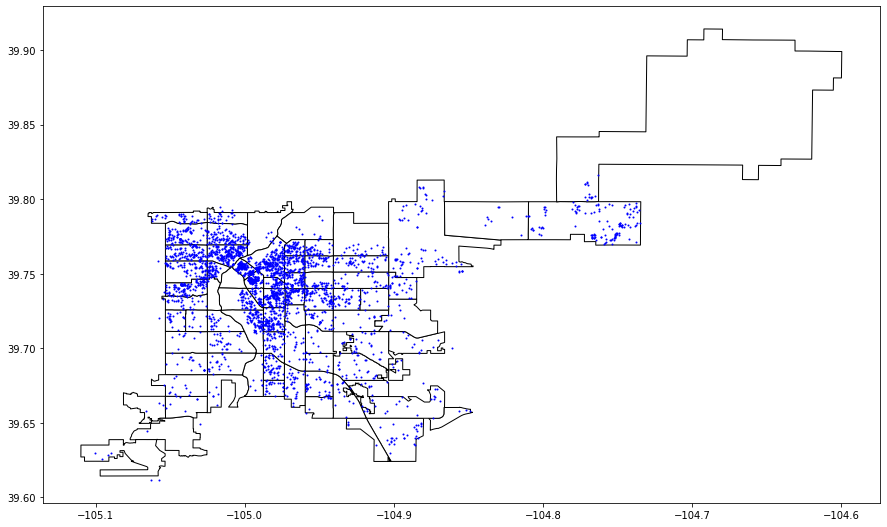

In [21]:
# Plot all the coordinates from the listings on the neighborhoods map
listings_gdf = gpd.GeoDataFrame(listings, geometry="coordinates")

fig, ax = plt.subplots(1, 1, figsize=(15, 15))

ax = neighborhoods_gdf.plot(color="white", edgecolor="black", ax=ax)
listings_gdf.plot(ax=ax, color="blue", markersize=1)

plt.show()

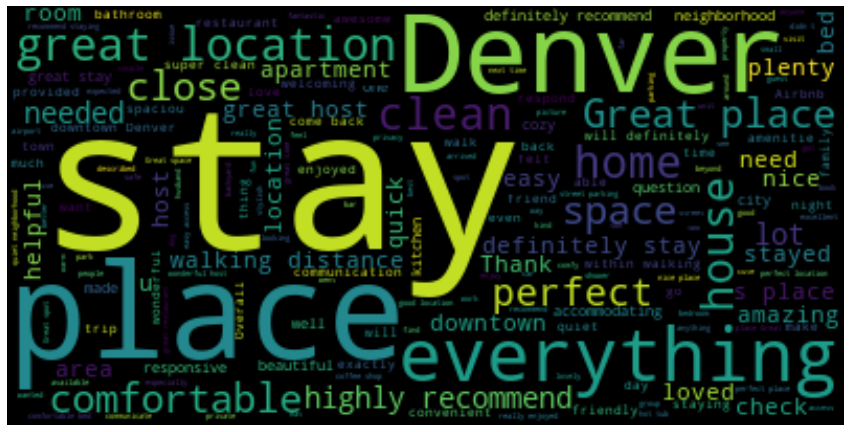

In [22]:
# make a word cloud with all the reviews text

# function to lump all the text together
def lumpText(text_array):
    lump = ""
    for i in text_array:
        lump += str(i) + " "
    return lump

# generate wordcloud
reviews_lump_text = lumpText(reviews["comments"].values)
reviews_wordcloud = WordCloud().generate(reviews_lump_text)

# plot
plt.figure(figsize=(15,10))
plt.imshow(reviews_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Neighbourhood price box plot


<AxesSubplot:xlabel='neighbourhood_group', ylabel='price'>

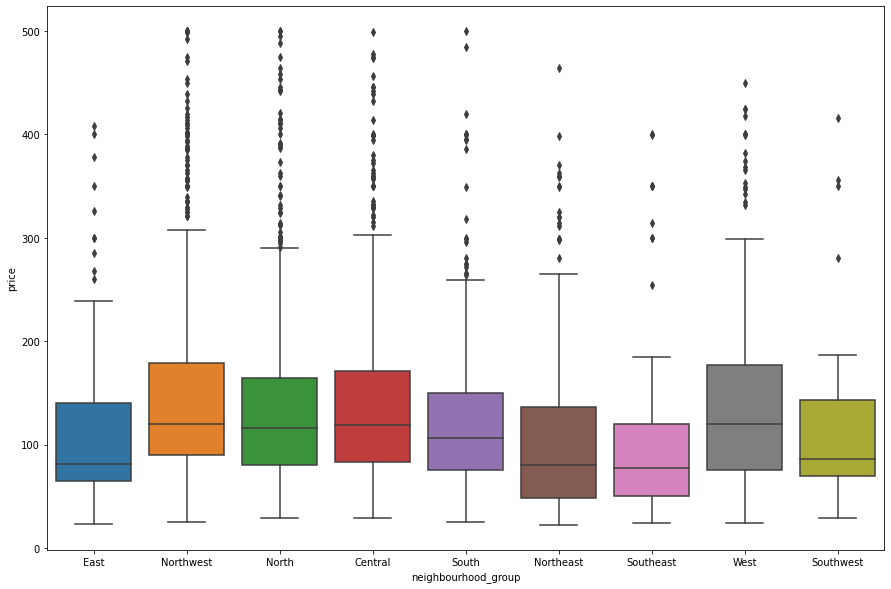

In [23]:
plt.figure(figsize=(15,10))
sns.boxplot(y='price',x='neighbourhood_group', data = listings[listings['price']<=500])

## Model

### Convert Categoircal Features to Numberic with LabelEncoder()

In [24]:
# creating instance of labelencoder
labelencoder = LabelEncoder()

# Assigning numerical values
for cat in catFeatures:
    listings[cat] = labelencoder.fit_transform(listings[cat])

listings[catFeatures].sample(3)

,host_location,host_response_time,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,property_type,room_type,has_availability,instant_bookable,private_bathroom,neighbourhood_group
1701,35,4,2,2,2,2,25,2,1,0,2,0
682,35,4,2,2,2,55,8,0,1,0,2,4
1435,119,2,0,2,0,15,4,0,1,0,2,0


### Splitting data into test train

In [25]:
from sklearn.model_selection import train_test_split

# Dependent variable: neighbourhood_group
y = listings['neighbourhood_group']

# Drop dependent variable and other variables that would tamper the results
X = listings.drop(['neighbourhood_group', 'id', 'host_id', 'neighbourhood_cleansed', 'coordinates'], axis=1)

In [26]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

### Fit Initial Model

In [27]:
# Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

# Create a Gaussian Classifier
rf=RandomForestClassifier(n_estimators=50)

# Train the model using the training sets y_pred=clf.predict(X_test)
rf.fit(X_train,y_train)

RandomForestClassifier(n_estimators=50)

In [28]:
y_pred = rf.predict(X_test)
y_pred

array([0, 0, 2, ..., 0, 0, 4])

## Model Evaluation

In [29]:
from sklearn import metrics

# First evaluate inital model to get a feel of the metrics
print('n_estimators = 50')
print('\tMean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('\tMean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('\tRoot Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

n_estimators = 50
	Mean Absolute Error: 1.7033398821218075
	Mean Squared Error: 6.950884086444008
	Root Mean Squared Error: 2.636452936512239


In [30]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[242   3  33   3  45   2   0   0   3]
 [ 17   3   8   3  17   0   1   0   2]
 [ 55   0  58   3  41   3   0   0   5]
 [ 24   2  13  28  13   0   0   0   0]
 [ 69   2  31   2 104   1   0   0   3]
 [ 18   0  13   1  21  12   0   0   1]
 [  5   3   2   5   2   0   4   0   0]
 [  3   0   1   0   4   0   0   1   0]
 [ 17   0  22   4  23   0   0   1  16]]
              precision    recall  f1-score   support

           0       0.54      0.73      0.62       331
           1       0.23      0.06      0.09        51
           2       0.32      0.35      0.34       165
           3       0.57      0.35      0.43        80
           4       0.39      0.49      0.43       212
           5       0.67      0.18      0.29        66
           6       0.80      0.19      0.31        21
           7       0.50      0.11      0.18         9
           8       0.53      0.19      0.28        83

    accuracy                           0.46      1018
   macro avg       0.51      0.30      0.33      101

In [31]:
# Make Evaluation Dataframe
evaluation = pd.DataFrame({'n_estimators': [],
                           'Mean Absolute Error':[],
                           'Mean Squared Error':[],
                           'Root Mean Squared Error (RMSE)':[],
                           'Accuracy':[]})

# Make for loop to graph RMSE & Accuracy for different n_estimators
for i in range(5, 201, 5):
    # Make Classifier & Fit
    rf = RandomForestClassifier(n_estimators=i)
    rf.fit(X_train, y_train)
    
    # Predict
    y_pred = rf.predict(X_test)
    
    # Calculate metrics
    mae = metrics.mean_absolute_error(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    accuracy = accuracy_score(y_test, y_pred)
    
    # append to evaluation data frame
    r = evaluation.shape[0]
    evaluation.loc[r] = [i,mae,mse,rmse,accuracy]

In [32]:
# Show evaluation dataframe
evaluation.sample(3)

,n_estimators,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error (RMSE),Accuracy
12,65.0,1.635560,6.350688,2.520057,0.459725
28,145.0,1.618861,6.412574,2.532306,0.474460
20,105.0,1.674853,6.470530,2.543724,0.444008


<AxesSubplot:xlabel='n_estimators'>

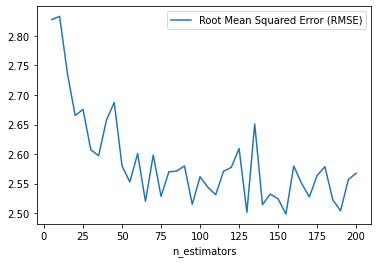

In [33]:
# Plot RMSE
evaluation.plot(kind='line',x='n_estimators',y='Root Mean Squared Error (RMSE)')

<AxesSubplot:xlabel='n_estimators'>

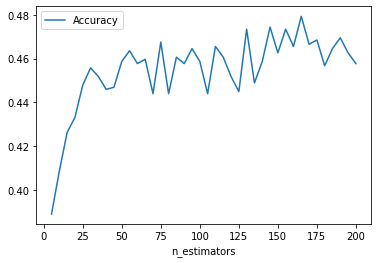

In [34]:
# Plot Accuracy
evaluation.plot(kind='line',x='n_estimators',y='Accuracy')

<AxesSubplot:xlabel='n_estimators'>

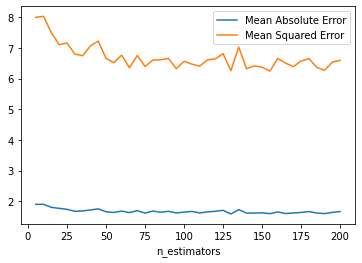

In [35]:
# Plot other Metrics
evaluation.plot(kind='line',x='n_estimators',y=['Mean Absolute Error', 'Mean Squared Error'])

## Model Selection

In [36]:
# Get row in dataframe where accuracy was the highest
best_model = evaluation.sort_values(by = "Accuracy", ascending = False).head(1)
best_model

,n_estimators,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error (RMSE),Accuracy
32,165.0,1.60609,6.505894,2.550665,0.479371


In [37]:
best_n = int(best_model['n_estimators'].iloc[0])
print("We saw best performace on a RandomForestClassifier with n_estimators = ", best_n)

We saw best performace on a RandomForestClassifier with n_estimators =  165


In [38]:
# Create a Gaussian Classifier
rf=RandomForestClassifier(n_estimators=best_n)

# Train the model using the training sets y_pred=clf.predict(X_test)
rf.fit(X_train,y_train)

RandomForestClassifier(n_estimators=165)

In [39]:
y_pred = rf.predict(X_test)
y_pred

array([0, 0, 4, ..., 0, 0, 4])

In [40]:
print('n_estimators = ', best_n)
print('\tMean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('\tMean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('\tRoot Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

n_estimators =  165
	Mean Absolute Error: 1.612966601178782
	Mean Squared Error: 6.275049115913556
	Root Mean Squared Error: 2.505004813550975


In [41]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[243   4  30   2  46   3   0   0   3]
 [ 14   3   9   3  18   3   1   0   0]
 [ 49   1  59   3  50   0   0   0   3]
 [ 19   3   8  27  21   2   0   0   0]
 [ 70   2  26   4 106   2   0   0   2]
 [ 19   0  13   1  20  12   0   0   1]
 [  4   0   2   4   5   0   6   0   0]
 [  3   0   1   0   4   0   0   1   0]
 [ 11   0  18   3  29   1   0   0  21]]
              precision    recall  f1-score   support

           0       0.56      0.73      0.64       331
           1       0.23      0.06      0.09        51
           2       0.36      0.36      0.36       165
           3       0.57      0.34      0.43        80
           4       0.35      0.50      0.41       212
           5       0.52      0.18      0.27        66
           6       0.86      0.29      0.43        21
           7       1.00      0.11      0.20         9
           8       0.70      0.25      0.37        83

    accuracy                           0.47      1018
   macro avg       0.57      0.31      0.36      101